In [3]:

import torch
import torch.nn as nn
from torchvision.transforms import transforms
import cv2
import numpy as np
import glob
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt


In [20]:
#YOLO
# Cargar los archivos de configuración y pesos
config_path = 'conf.cfg'
weights_path = 'pesos.weights'
names_path = 'obj.names'

# Cargar la lista de nombres de clases
with open(names_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Cargar el modelo YOLOv4
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Obtener la lista de capas de salida
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Obtener la lista de archivos de imagen en la carpeta "fotos"
image_folder = r'.\fotos'
image_files = glob.glob(image_folder + '*.png') + glob.glob(image_folder + '*.jpg')

# Iterar sobre cada imagen
for image_path in image_files:
    # Cargar la imagen de entrada
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Preprocesar la imagen para que se ajuste a la entrada del modelo
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Establecer la entrada del modelo
    net.setInput(blob)

    # Ejecutar la detección de objetos
    layer_outputs = net.forward(output_layers)

    # Recopilar información sobre detecciones de personas
    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Clase 0 es para personas

                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    max_area = 0
    max_box = None

    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        area = w * h

        if area > max_area:
            max_area = area
            max_box = (x, y, w, h)

    if max_box is not None:
        x, y, w, h = max_box
        label = class_names[class_ids[i]]
        confidence = confidences[i]

        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f'{label}: {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow('YOLOv4 Detection', image)

    key = cv2.waitKey(0)
    if key == ord('s'):
        continue
    break

cv2.destroyAllWindows()


In [21]:
def det_persona_yolo(image):
    # Convertir la imagen a un arreglo de Numpy
    image = np.array(image)

# Convertir la imagen de BGR (formato de OpenCV) a RGB (formato de PIL)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channels = image.shape

    # Preprocesar la imagen para que se ajuste a la entrada del modelo
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Establecer la entrada del modelo
    net.setInput(blob)

    # Ejecutar la detección de objetos
    layer_outputs = net.forward(output_layers)

    # Recopilar información sobre detecciones de personas
    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Clase 0 es para personas
                # Escalar las coordenadas de la caja delimitadora al tamaño de la imagen original
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Calcular las coordenadas de la esquina superior izquierda de la caja delimitadora
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                # Verificar si se encontró alguna persona en la imagen

    # Aplicar supresión no máxima para eliminar detecciones superpuestas
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Encontrar el bounding box de mayor área
    max_area = 0
    max_box = None

    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        area = w * h

        if area > max_area:
            max_area = area
            max_box = (x, y, w, h)

    # Dibujar el bounding box de mayor área en la imagen
    if max_box is not None:
        x, y, w, h = max_box
        # Verificar que las coordenadas estén dentro de los límites de la imagen
        x = max(0, x)
        y = max(0, y)
        w = min(w, width - x)
        h = min(h, height - y)
        label = class_names[class_ids[i]]
        confidence = confidences[i]
        if w > 0 and h > 0:
            roi = image[y:y + h, x:x + w]
            roi = Image.fromarray(roi)
            return roi

    # Si no se encontró ninguna ROI válida, retornar None
    return None

In [2]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=5):
        super(ConvNet,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)

        self.bn1=nn.BatchNorm2d(num_features=12)

        self.relu1=nn.ReLU()
        
        self.pool=nn.MaxPool2d(kernel_size=2)    
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)

        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
                     
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

In [7]:
model_path = 'best_checkpoint.model'
model = ConvNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
resnet= nn.Sequential(*list(model.children())[:-1])  # Elimino la última capa

_5.jpg 487.5607604980469
__211.jpg 489.74945068359375
__265.jpg 505.5862731933594
__73.jpg 507.38763427734375
__913.jpg 509.3378601074219


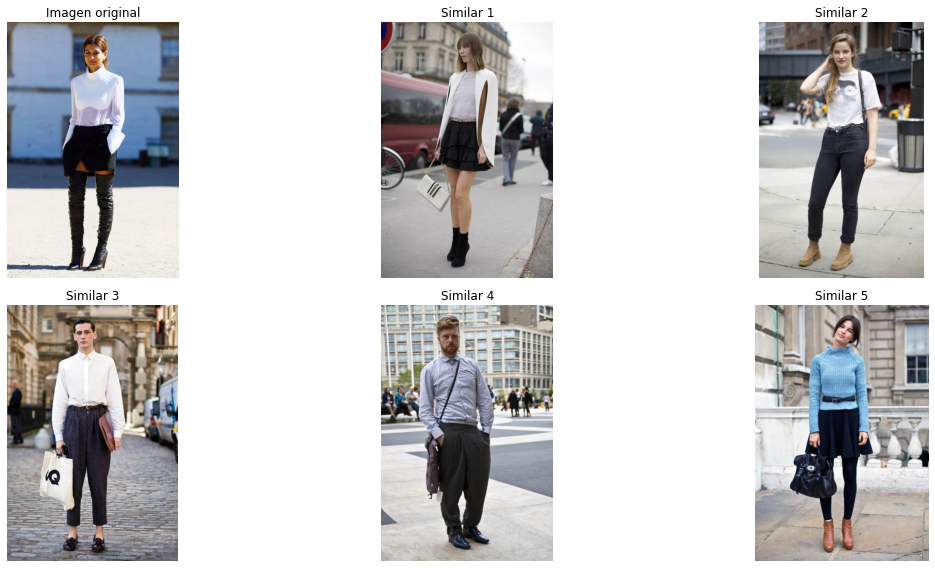

In [24]:
folder_path = r'.\fotos' 
resnet.eval()
img_path = '0012.jpg'
img = Image.open(img_path)
img = det_persona_yolo(img)

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = resnet(img_tensor)

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)
    img=det_persona_yolo(img)
    # Transformar la imagen
    if img is None:
        continue  # Saltar al siguiente ciclo si la ROI es None
    # Transformar la imagen
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = resnet(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)
# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0012.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

__863.jpg 623.6151733398438
__418.jpg 650.125
__305.jpg 673.0524291992188
__781.jpg 682.8648681640625
__331.jpg 693.2028198242188


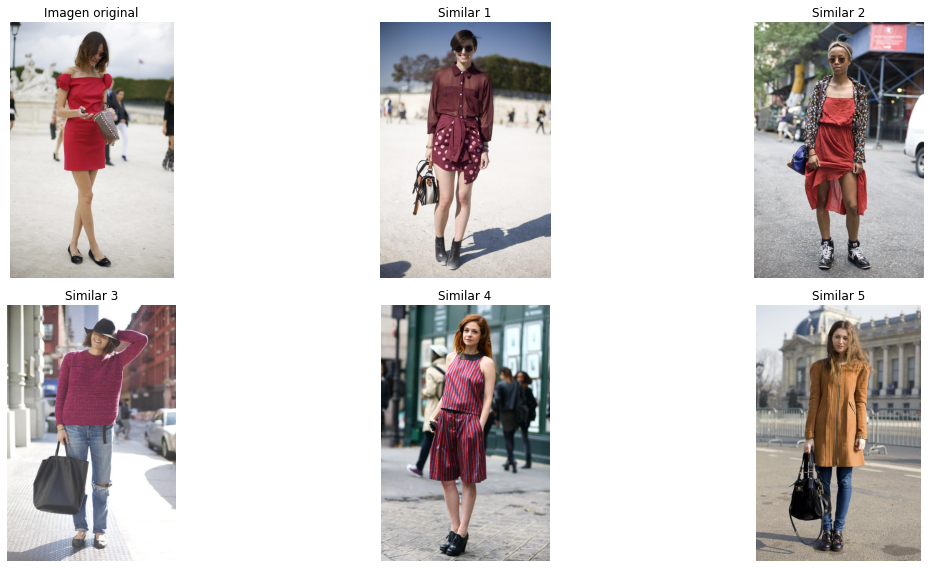

In [26]:
# Directorio de las imágenes
folder_path = r'.\fotos' 

resnet.eval()

img_path = '2096.jpg'
img = Image.open(img_path)
img = det_persona_yolo(img)

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = resnet(img_tensor)

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)
    img=det_persona_yolo(img)
    # Transformar la imagen
    if img is None:
        continue  # Saltar al siguiente ciclo si la ROI es None
    # Transformar la imagen
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = resnet(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)
# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '2096.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

__735.jpg 777.3007202148438
__500.jpg 859.4097900390625
__295.jpg 874.7207641601562
__876.jpg 922.9686889648438
_____7.jpg 928.018310546875


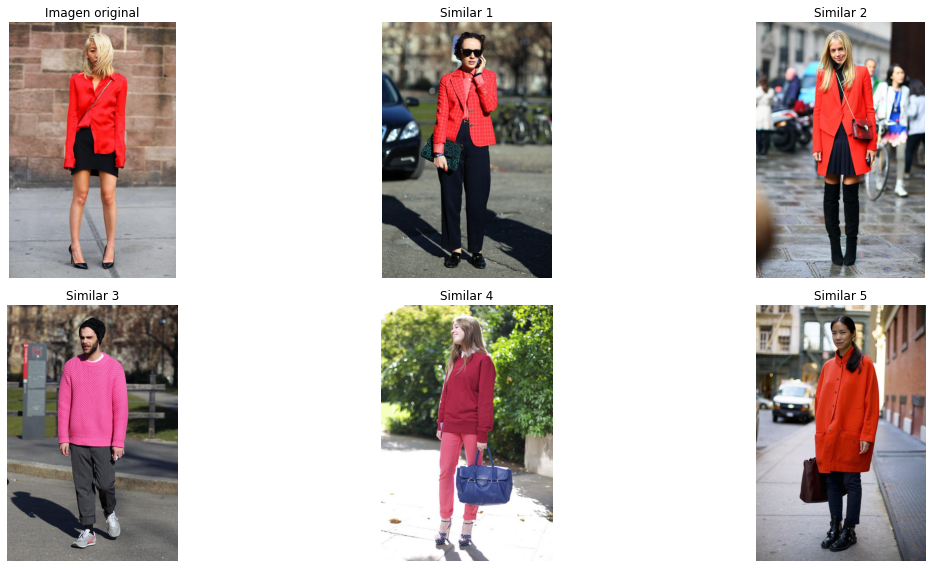

In [28]:
# Directorio de las imágenes
folder_path = r'.\fotos' 

resnet.eval()
img_path = 'ROJO.jpg'
img = Image.open(img_path)
img = det_persona_yolo(img)

# Preprocesamiento de imágenes
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = resnet(img_tensor)
# Ruta de la carpeta que contiene las imágenes de referencia

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)
    img=det_persona_yolo(img)
    # Transformar la imagen
    if img is None:
        continue  # Saltar al siguiente ciclo si la ROI es None
    # Transformar la imagen
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = resnet(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)
# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = 'ROJO.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()